Copyright **`(c)`** 2025 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [2]:
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt

## Load test problem

In [31]:
test_problem = np.load(r'problems\problem_r1_10.npy')
NUM_CITIES = test_problem.shape[0]

## Problem specific elements

In [4]:
class Individual:
    def __init__(self, genotype, distance):
        self.genotype = genotype  
        self.distance = distance   
    
    def __repr__(self):
        return f"Individual(genotype={self.genotype}, distance={self.distance})"

In [14]:
def cost(tour, test_problem):
    total = 0
    for i in range(len(tour)-1):
        dist = test_problem[tour[i],tour[i+1]]
        total += dist
    dist = test_problem[tour[-1],tour[0]] # go back to start
    total += dist
    return total

In [ ]:
def genotype():
    return random.sample(range(NUM_CITIES), NUM_CITIES)

# SELECTION
two possible selection strategies were considered
- tournament selection: randomly select #TAU individuals from population, choose best one
- roulette wheel: fitness proportional, choose best one depending on relative fitness of the individual

In [6]:
def tournament_selection(population: list[Individual], tau: int) -> Individual:
    pool = random.choices(population, k=tau)
    return max(pool, key=lambda i: i.distance)

In [7]:
def roulette_wheel(population: list[Individual], NUM):
    fitnesses = np.array([1.0 / ind.distance for ind in population])
    probabilities = fitnesses / fitnesses.sum() #normalize
    return np.random.choice(population, size=1, p=probabilities)[0] # because np is an array array([x])

# GENETIC OPERATORS
initial to study behaviour of problem only two basic operators were considered

In [29]:
def swap_mutation(individual: Individual):
    # swap two random cities
    new_genotype = individual.genotype[:]
    i, j = random.sample(range(NUM_CITIES), 2)
    new_genotype[i], new_genotype[j] = new_genotype[j], new_genotype[i]
    return Individual(new_genotype, None)

In [30]:
def order_crossover(p1: Individual, p2: Individual):
    start, end = sorted(random.sample(range(NUM_CITIES), 2))
    child = [None] * NUM_CITIES
    # Copy slice from parent 1
    child[start:end] = p1.genotype[start:end]

    # Fill remaining with parent 2’s cities, in order
    p2_seq = [city for city in p2.genotype if city not in child]
    fill_idx = 0
    for i in range(NUM_CITIES):
        if child[i] is None:
            child[i] = p2_seq[fill_idx]
            fill_idx += 1

    return Individual(child, None)

# PARAMETERS

In [ ]:
POPULATION_SIZE = 100 # (μ)
# healthy amount of genetic diversity without being computationally excessive for a 10-city problem.
OFFSPRING_SIZE = 50    # (λ) 
# Using a (μ+λ) model
TAU = 3   # (τ) Small size prevents premature convergence


NUM_GENERATIONS = 400

# IMPLEMENTATION

In [19]:
def ea_simple(POPULATION_SIZE, OFFSPRING_SIZE, TAU, NUM_GENERATIONS, parent_selection):  
    current_population = [
        Individual(random.sample(range(NUM_CITIES), NUM_CITIES), None)
        for _ in range(POPULATION_SIZE)
    ]

    for ind in current_population:
        ind.distance = cost(ind.genotype, test_problem)

    current_population.sort(key=lambda ind: ind.distance)

    best_distance = float('inf')  # smaller is better
    generation = 0
    evaluations = 0

    MUTATION_RATE = max(0.05, 0.5 * (1 - generation / NUM_GENERATIONS))

    stats = []

    while generation < NUM_GENERATIONS:
        generation += 1
        offspring = []

        MUTATION_RATE = max(0.05, 0.5 * (1 - generation / NUM_GENERATIONS))

        for _ in range(OFFSPRING_SIZE):
            if random.random() < MUTATION_RATE:
                parent = parent_selection(current_population, TAU)
                child = swap_mutation(parent)
            else:
                p1 = parent_selection(current_population, TAU)
                p2 = parent_selection(current_population, TAU)
                # make sure they're not the same
                while p2 is p1:
                    p2 = parent_selection(current_population,TAU)
                child = order_crossover(p1, p2)
            offspring.append(child)

        for child in offspring:
            child.distance = cost(child.genotype, test_problem)
        evaluations += len(offspring)

        current_population.extend(offspring) # ((μ+λ))
        current_population = sorted(current_population, key=lambda i: i.distance)
        current_population = current_population[:POPULATION_SIZE]

        if current_population[0].distance < best_distance:
            best_distance = current_population[0].distance

        stats.append((generation, best_distance))
    return stats, best_distance


<Figure size 1200x800 with 0 Axes>

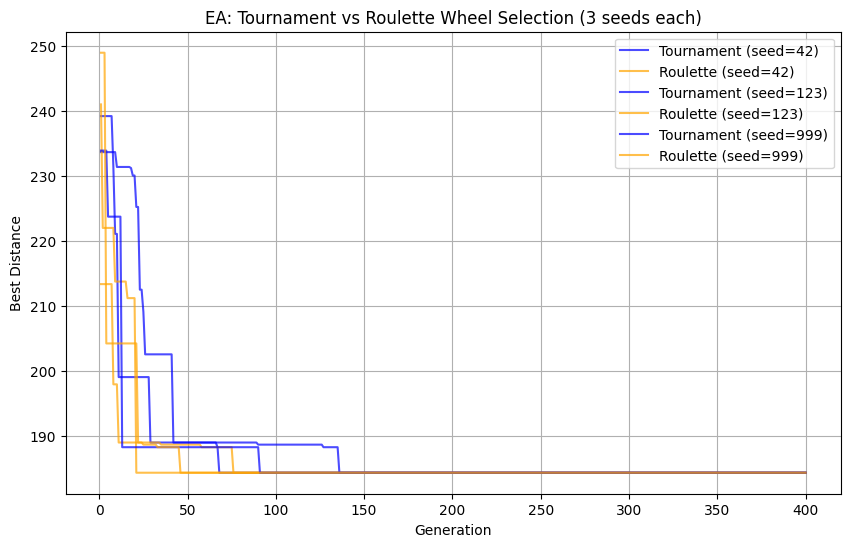

Seed 42 | Tournament → Best Distance = 184.27
Seed 42 | Roulette   → Best Distance = 184.27
Seed 123 | Tournament → Best Distance = 184.27
Seed 123 | Roulette   → Best Distance = 184.27
Seed 999 | Tournament → Best Distance = 184.27
Seed 999 | Roulette   → Best Distance = 184.27


In [20]:
# compare the two different parent selection behaviours
seeds = [42, 123, 999]

plt.figure(figsize=(12, 8))
final_bests = []

selection_methods = {
    "Tournament": tournament_selection,
    "Roulette": roulette_wheel
}

results = []

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)

    for method_name, selection_fn in selection_methods.items():
        stats, best_distance = ea_simple(
            POPULATION_SIZE,
            OFFSPRING_SIZE,
            TAU,
            NUM_GENERATIONS,
            parent_selection=selection_fn
        )
        results.append({
            "seed": seed,
            "method": method_name,
            "stats": stats,
            "best_distance": best_distance
        })

plt.figure(figsize=(10, 6))

colors = {"Tournament": "blue", "Roulette": "orange"}

for result in results:
    generations = [g for g, _ in result["stats"]]
    best_distances = [d for _, d in result["stats"]]
    plt.plot(
        generations,
        best_distances,
        label=f"{result['method']} (seed={result['seed']})",
        color=colors[result["method"]],
        alpha=0.7
    )

plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.title("EA: Tournament vs Roulette Wheel Selection (3 seeds each)")
plt.grid(True)
plt.legend()
plt.show()

for result in results:
    print(f"Seed {result['seed']:>2} | {result['method']:<10} → Best Distance = {result['best_distance']:.2f}")

from now on, `roulette_wheel` selection strategy will be implemented

In [21]:
def ea_combos(mutation_function, crossover_function, selection_function, seed=1):  
    current_population = [
        Individual(random.sample(range(NUM_CITIES), NUM_CITIES), None)
        for _ in range(POPULATION_SIZE)
    ]

    for ind in current_population:
        ind.distance = cost(ind.genotype, test_problem)

    current_population.sort(key=lambda ind: ind.distance)

    best_distance = float('inf')  # smaller is better
    best_individual = []
    generation = 0
    evaluations = 0

    stats = []

    while generation < NUM_GENERATIONS:
        generation += 1
        offspring = []

        MUTATION_RATE = max(0.05, 0.5 * (1 - generation / NUM_GENERATIONS))

        for _ in range(OFFSPRING_SIZE):
            if random.random() < MUTATION_RATE:
                parent = selection_function(current_population, TAU)
                child = mutation_function(parent)
            else:
                p1 = selection_function(current_population, TAU)
                p2 = selection_function(current_population, TAU)
                # make sure they're not the same
                attempts = 0
                while p2 is p1 and attempts < 10: 
                    p2 = selection_function(current_population, TAU)
                    attempts += 1
                while p2 is p1:
                    p2 = selection_function(current_population,TAU)
                child = crossover_function(p1, p2)
            offspring.append(child)

        for child in offspring:
            child.distance = cost(child.genotype, test_problem)
        evaluations += len(offspring)

        current_population.extend(offspring)
        current_population = sorted(current_population, key=lambda i: i.distance)  # ascending
        current_population = current_population[:POPULATION_SIZE]

        if current_population[0].distance < best_distance:
            best_distance = current_population[0].distance
            best_individual = current_population[0].genotype

        stats.append((generation, best_distance))
    return stats, best_distance, best_individual

In [22]:
# test two different mutation operators

def insert_mutation(individual: Individual):
    new_genotype = individual.genotype[:]
    i, j = random.sample(range(NUM_CITIES), 2)
    city = new_genotype.pop(j)
    new_genotype.insert(i + 1, city)
    return Individual(new_genotype, None)

def inversion_mutation(individual: Individual):
    new_genotype = individual.genotype[:]
    i, j = sorted(random.sample(range(NUM_CITIES), 2))
    new_genotype[i:j] = reversed(new_genotype[i:j])
    return Individual(new_genotype, None)


printing swap_mutation and order_crossover
printing insert_mutation and order_crossover
printing inversion_mutation and order_crossover


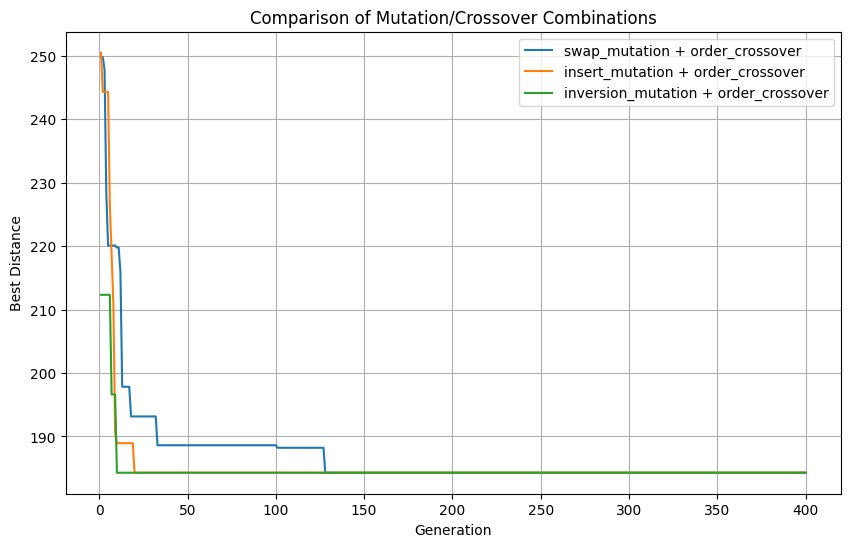

Best: swap_mutation + order_crossover → 184.27 [8, 0, 4, 5, 3, 6, 2, 9, 7, 1]


In [23]:
muts = [swap_mutation, insert_mutation,inversion_mutation]
cross = [order_crossover]

all_stats = {}
stats = []
total_best = 1e6
best_policies = (None, None)

combos = list(itertools.product(muts, cross))

for m,c in combos:
    print(f"printing {m.__name__} and {c.__name__}")
    stats, best_dist, best_ind = ea_combos(m,c, roulette_wheel)
    all_stats[(m.__name__, c.__name__)] = stats
    if best_dist < total_best:
        total_best = best_dist
        best_policies = (m,c)

plt.figure(figsize=(10, 6))

for (m_name, c_name), stats in all_stats.items():
    generations = [g for g, _ in stats]
    best_distances = [d for _, d in stats]
    plt.plot(generations, best_distances, label=f"{m_name} + {c_name}")

plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.title("Comparison of Mutation/Crossover Combinations")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best: {best_policies[0].__name__} + {best_policies[1].__name__} → {total_best:.2f} {best_ind}")

As is to be expected, the results of these algorithms don't vary drastically; in any case the results are stochastic and dependant on the seed, a different seed might have produced slightly different results.
For simplicity, we will consider from now on only inversion_mutation and order_crossover

# Application
Now we apply our results to out test problems

In [26]:
from itertools import combinations
import os
import time
import numpy as np  

POPULATION_SIZE = 100
OFFSPRING_SIZE = 50

PROBLEMS_FOLDER = "problems"
problem_files = [f for f in os.listdir(PROBLEMS_FOLDER) if f.endswith(".npy")]

num_runs = 5
seeds = [42, 123, 999, 2024, 77]
results = []

for problem_file in problem_files:
    
    test_problem = np.load(os.path.join(PROBLEMS_FOLDER, problem_file))
    print(f"\nRunning EA on problem: {problem_file}")
    start_time = time.time()

    # check for problem constraints

    if np.any(test_problem < 0):
        print(f"Skipping {problem_file}: contains negative distances.")
        continue
    if not np.allclose(test_problem, test_problem.T, atol=1e-8):
        print(f"{problem_file}: not symmetric.")
    if not all(
        test_problem[x,y] <= test_problem[x,z] + test_problem[z,y]
        for x,y,z in list(combinations(range(test_problem.shape[0]),3))
    ):
        print(f"{problem_file}: Triangle inequality violated.")
    

    NUM_CITIES = test_problem.shape[0]
    NUM_GENERATIONS = NUM_CITIES * 150

    run_results = []

    for seed in seeds:
        stats, best, _ = ea_combos(
            inversion_mutation, order_crossover, roulette_wheel, seed=seed
        )
        run_results.append((seed, best, stats))

    elapsed = time.time() - start_time

    best_overall = min(r[1] for r in run_results)
    threshold = best_overall * 1.05  # within 5%
    successes = sum(1 for _, b, _ in run_results if b <= threshold)
    success_rate = successes / len(run_results)

    results.append({
        "problem_file": problem_file,
        "best_overall": best_overall,
        "success_rate": success_rate,
        "runtime_sec": elapsed
    })

    print(f"Best: {best_overall:.2f}, Success rate: {success_rate*100:.1f}%")
    print(f"Time elapsed: {elapsed:.2f}s")



Running EA on problem: problem_g_10.npy
Best: 1497.66, Success rate: 100.0%
Time elapsed: 65.42s

Running EA on problem: problem_g_100.npy
Best: 4052.34, Success rate: 80.0%
Time elapsed: 872.45s

Running EA on problem: problem_g_20.npy
Best: 1755.51, Success rate: 100.0%
Time elapsed: 133.00s

Running EA on problem: problem_g_50.npy
Best: 2730.69, Success rate: 80.0%
Time elapsed: 359.41s

Running EA on problem: problem_r1_10.npy
problem_r1_10.npy: not symmetric.
problem_r1_10.npy: Triangle inequality violated.
Best: 184.27, Success rate: 100.0%
Time elapsed: 67.97s

Running EA on problem: problem_r1_100.npy
problem_r1_100.npy: not symmetric.
problem_r1_100.npy: Triangle inequality violated.
Best: 1443.04, Success rate: 20.0%
Time elapsed: 862.88s

Running EA on problem: problem_r1_20.npy
problem_r1_20.npy: not symmetric.
problem_r1_20.npy: Triangle inequality violated.
Best: 337.29, Success rate: 40.0%
Time elapsed: 134.36s

Running EA on problem: problem_r1_50.npy
problem_r1_50.npy